In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
TT = TT.drop([
    'GlaThiDa_ID',
    'POLITICAL_UNIT',
    'GLACIER_NAME',
    'SURVEY_DATE',
#     'LOWER_BOUND',
#     'UPPER_BOUND',
#     'AREA',
#     'MEAN_SLOPE',
    'MEAN_THICKNESS',
    'MEAN_THICKNESS_UNCERTAINTY',
#     'MAXIMUM_THICKNESS',
    'MAX_THICKNESS_UNCERTAINTY',
    'DATA_FLAG',
    'REMARKS'
],axis=1)
TT = TT.dropna()
TT

,LOWER_BOUND,UPPER_BOUND,AREA,MEAN_SLOPE,MAXIMUM_THICKNESS
81,2600,2650,0.01985,24.0,29.0
82,2650,2700,0.03433,20.0,36.0
83,2700,2750,0.02145,23.0,23.0
84,2750,2800,0.00505,28.0,10.0
85,2540,2560,0.00660,4.0,10.0
...,...,...,...,...,...
406,4700,4800,0.47900,21.0,112.0
407,4800,4900,0.55900,23.0,91.0
408,4900,5000,0.54500,26.0,83.0
409,5000,5100,0.37900,24.0,36.0


### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = TT.sample(frac=0.8, random_state=0)
test_dataset = TT.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('MAXIMUM_THICKNESS')
test_labels = test_features.pop('MAXIMUM_THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LOWER_BOUND,3205.591270,825.956760
UPPER_BOUND,3254.769841,841.514265
AREA,0.173664,0.356148
MEAN_SLOPE,24.015873,11.599206


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/4 [00:00<?, ?it/s]2022-03-23 16:36:45.459203: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-23 16:36:45.459262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-23 16:36:45.460404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


In [5]:
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [6]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 4/4 [00:12<00:00,  3.16s/it]

CPU times: user 16 s, sys: 5.83 s, total: 21.9 s
Wall time: 12.6 s


In [7]:
# fig,ax=plt.subplots(2,6,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
# #     mpl_style("dark")
#     ax = plt.subplot(4,4,i+1)
#     plt.subplot(4,4,i+1)
#     gl.plot_loss(linear_history[variable_name])
#     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [8]:
linear_model = gl.build_linear_model(normalizer['ALL'])

linear_history['MULTI'] = linear_model.fit(
train_features, train_labels,        
   epochs=100,
   verbose=0,
   validation_split = 0.2)

linear_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [9]:
# gl.plot_loss(history_full)
# # plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [10]:
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [11]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


In [12]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,variable_name)

In [14]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# fig.patch.set_facecolor('w')
# for i, variable_name in enumerate(variable_list):
#     ax = plt.subplot(4,4,i+1)
#     gl.plot_loss(dnn_history[variable_name])
#     ax.set_ylim([20,35])
#     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
# plt.tight_layout()

# Full model

In [15]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

dnn_history['MULTI'] = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

dnn_results['MULTI'] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [17]:
# gl.plot_loss(dnn_history['MULTI'])
# # plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

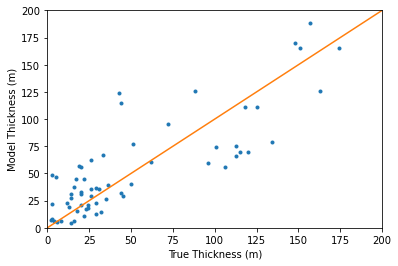

In [18]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

# Collect Results

In [19]:
dfs = pd.DataFrame()
for variable_name in list(dnn_history):    
    df1 = pd.DataFrame(dnn_history[variable_name].history)
    df1 = df1.loc[[df1.last_valid_index()]]
    df1['Architecture'] = 'DNN'
    df1.insert(0, 'Variable', [variable_name])

    df2 = pd.DataFrame(linear_history[variable_name].history)
    df2 = df2.loc[[df2.last_valid_index()]]
    df2['Architecture'] = 'Linear'
    df2.insert(0, 'Variable', [variable_name])
    
    df = pd.concat([df1,df2])
    dfs = dfs.append(df)
    
df = dfs[[
    'Architecture',
    'Variable',
    'loss',
    'val_loss'
]]
df.rename(columns = {
    'loss':'Training Loss',
    'val_loss':'Test loss'
},inplace=True)
df = df.sort_values(by=['Architecture','Variable'], ascending=[False,False])
print(df.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Architecture &    Variable &  Training Loss &  Test loss \\
\midrule
      Linear & UPPER\_BOUND &      26.107384 &  23.396553 \\
      Linear &       MULTI &      23.583166 &  18.927683 \\
      Linear &  MEAN\_SLOPE &      29.524456 &  25.116495 \\
      Linear & LOWER\_BOUND &      26.245781 &  23.339584 \\
      Linear &        AREA &      33.106766 &  27.172272 \\
         DNN & UPPER\_BOUND &      24.914684 &  22.887007 \\
         DNN &       MULTI &      16.179424 &  16.949188 \\
         DNN &  MEAN\_SLOPE &      27.105177 &  26.666466 \\
         DNN & LOWER\_BOUND &      25.615721 &  25.025976 \\
         DNN &        AREA &      23.119791 &  24.687021 \\
\bottomrule
\end{tabular}

